## Human Mortality rates

Let us examine different models of death rate and compare them to experience:
### 1 - The lightning bolt model
Death is the result of a random event whose probability is constant over time.  
This model is correct if death is essentially the result of accidents, or the whim of gods, who randomly strike at a constant rate. If an individual receives a strike, they die.  
    
    
### 2 - The accumulated lightning bolt model
Death is the result of receiving the n-th lightning bolts, which occur randomly at a constant rate, like in the previous model.  
This model is correct if an individual is alive as long as their have enough "life points". Each individual  starts with say $k$ points and each random lightning bolts takes out one point.  
This model is a generalisation of the Lightning bolt model.  

### 3 - The Gombertz model
Death occurs at a rate than grows exponentially over time.  
It is correct if death occurs when toxic agents (e.g. microbs, cancer cells) appearing in the body at a constant rate are left alone long enough, and cleaner agents (immune reponse) are exponentially rare.  
(See this [article](https://arxiv.org/PS_cache/q-bio/pdf/0411/0411019v3.pdf))

_First remember we are dealing with a serious topic that one day will concern you too._

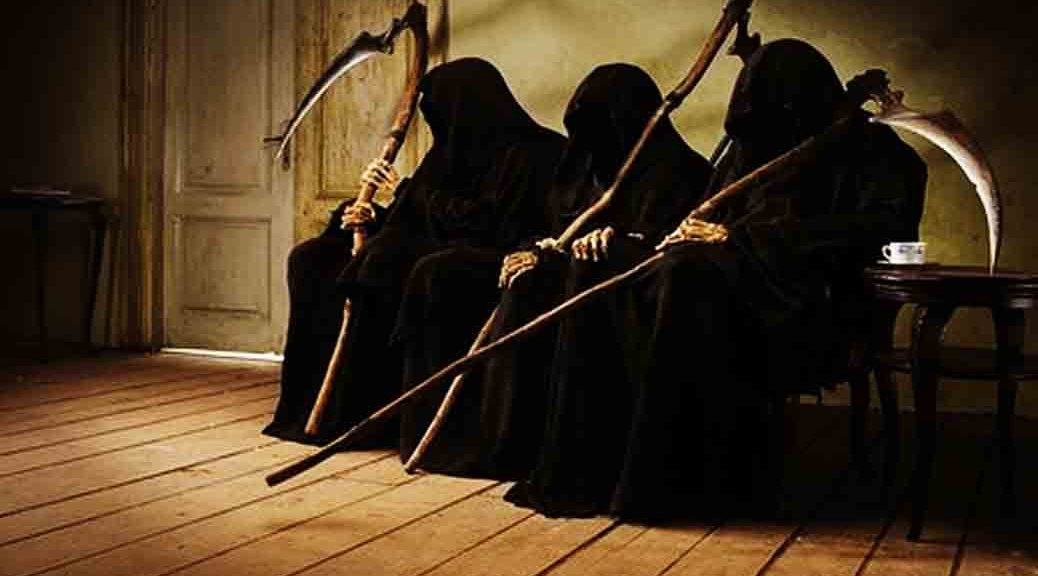

In [1]:
import os
from IPython.display import Image
Image(os.path.join('data', 'law-of-death.jpg'), width='80%')

Let us examine life expectancy statistics for the **accumulated lightning bolt model** and the **Gombertz model**.

### The accumulated lightning bolt model
The number of lightning bolts ($X$) per year follows a Poisson distribution.  
The law [PMF](https://en.wikipedia.org/wiki/Probability_mass_function) is $$f(k, \lambda) = P(X=k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

The mean $\lambda$ of this distribution must be $k/80$ if we assume that people die at 80 on average after $k$ lightning bolts.  

$$\lambda=k/80$$

In order to asses the survival probability we need the distribution time it takes to have $k$ lightning bolts over a period of time.  
This is the [Erlang distribution](https://en.wikipedia.org/wiki/Erlang_distribution). (called the [Exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution) for special case $k=1$)  
Its [PDF](https://en.wikipedia.org/wiki/Probability_density_function) is
$$f(x, k, \lambda)=\frac{\lambda^kx^{k-1}e^{-\lambda x}}{(k-1)!}$$

Its [CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function) is
$$f(x, k, \lambda)=\frac{\gamma(k, \lambda x)}{(k-1)!}$$
where $\gamma$ is is the [lower incomplete gamma function](https://en.wikipedia.org/wiki/Incomplete_gamma_function)
$$\gamma(s, x)=\int_{0}^{x}t^{s-1}e^{-t}dt$$

This CDF function represents the death probability of an individual vs. age.  
So 1-CDF function represents the survival probability of an individual vs. age.  
Let us plot it for age up to 300 years.

In [2]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')

%matplotlib inline

import os
import numpy as np
import pandas as pd
from scipy.special import gamma, gdtr, factorial
from fractions import Fraction

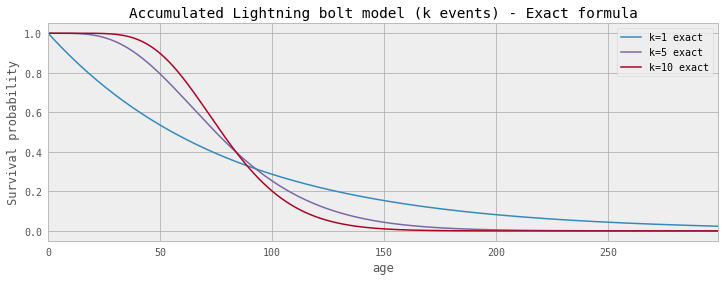

In [3]:
def cdf_erlang(x, k, lbd):
    return gamma(k)*gdtr(1, k, lbd*x)/factorial(k-1, exact=True)

avg_age = 80
x = np.arange(300)
df = pd.DataFrame(index=x)
df.index.name = 'age'

for k in [1, 5, 10]:
    lbd = k/(avg_age)
    y = cdf_erlang(x, k, lbd)
    df['k='+str(k)+' exact'] = 1-y.copy()

ax = df.plot(figsize=(12, 4),
             title='Accumulated Lightning bolt model (k events) - Exact formula')
ax.set_ylabel('Survival probability');

### Monte Carlo simulation

Let us make sure we did make a mistake and try and find the same results using naive montecarlo simulation.  

First let us create an array of random events of size (N_mc x max_age).  
N_mc is the number of monte carlo simulation.  
max_age is 300, as above.  
This models a lightning blow per year for N_mc different individuals.  


In [4]:
max_age = 300
N_mc = int(1e3)
rnd = np.random.uniform(0, 1, size=(N_mc, max_age))

rnd.shape

(1000, 300)

Each individual dies at age equal to the first $k$-th event which occurs at a random rate of $\lambda=k/80$.  
The monte carlo CDF is the fraction of individual living up to a certain age.  

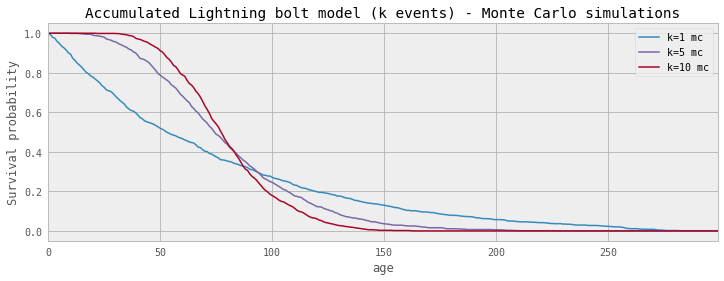

In [5]:
df_mc = pd.DataFrame(index=x)
df_mc.index.name = 'age'

for k in [1, 5, 10]:
    lbd = k/(avg_age)
    li_pos = []
    for i in range(N_mc):
        events = np.where((rnd[i, :]<lbd)==True)[0]
        pos_event = events[k-1] if len(events)>=k else max_age
        li_pos.append(pos_event)
    age_death = np.array(li_pos)
    hist, bin_edges = np.histogram(age_death, bins=np.arange(max_age), density=True)
    y = np.r_[0, np.cumsum(hist*np.diff(bin_edges))]
    df_mc['k='+str(k)+' mc'] = 1-y.copy()

ax = df_mc.plot(figsize=(12, 4),
                title='Accumulated Lightning bolt model (k events) - Monte Carlo simulations')
ax.set_ylabel('Survival probability');

The plots do look similar.  
Let us see in detail.   

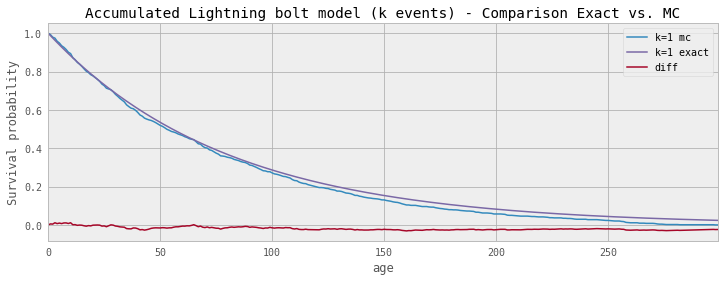

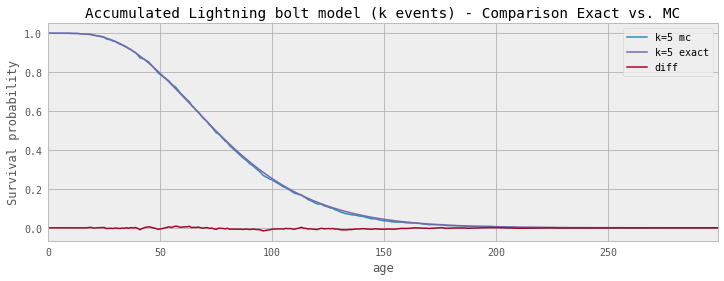

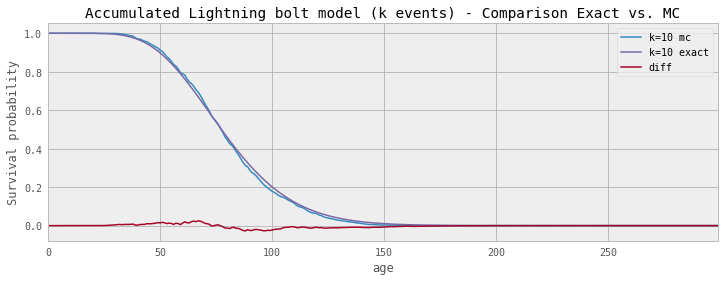

In [6]:
dfp = pd.concat([df, df_mc], axis=1)
for k in [1, 5, 10]:
    dfp1 = dfp[['k='+str(k)+' mc', 'k='+str(k)+' exact']]
    dfp1 = dfp1.assign(diff=(dfp1.iloc[:, 0]-dfp1.iloc[:, 1]))
    ax = dfp1.plot(figsize=(12, 4),
                   title='Accumulated Lightning bolt model (k events) - Comparison Exact vs. MC')
    ax.set_ylabel('Survival probability')

Ok.  
The curves are the almost the same even for a relatively small N_mc.

### Conclusion
The accumulated lightning bolt model does not account for reality - at all. At least for k up to 10.  
Indeed nobody has ever seen people aged 150 or more, however protective and peaceful and cosy the environment is.  
Even on the [Gods blessed Greek islands](http://www.nytimes.com/2012/10/28/magazine/the-island-where-people-forget-to-die.html) !   
However they appear to be non negligeable in this model.


### Real World data

An extract from the [World Health Organization database](http://apps.who.int/healthinfo/statistics/mortality/causeofdeath_query/) for France in 2013 show the following actual death rate.  

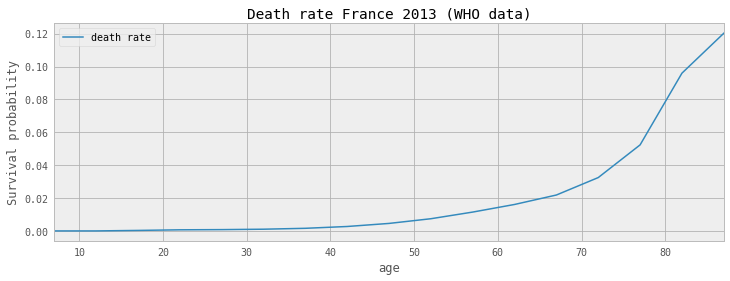

In [7]:
df2 = pd.read_csv(os.path.join('data', 'who_death_rate_france_2013.csv')).set_index('age')

ax = df2.plot(figsize=(12, 4),
              title = 'Death rate France 2013 (WHO data)')
ax.set_ylabel('Survival probability');

### The Gombertz model

[Benjamin Gombertz](https://en.wikipedia.org/wiki/Benjamin_Gompertz) proposed this empirical law in 1825.  
It states that the mortality rate or an individual with time $\mu(t)$ increases exponentially.  
$$\mu(t) = \alpha~e^{\beta t}$$
where $\alpha$ and $\beta$ are 2 constants to calibrate.

The CDF of this law is
$$1-exp(-\frac{\alpha}{\beta}(e^{\beta x} -1))$$

The empirical value for $\beta$ is such that [<span style="color: red;">**death rate doubles every 8 years**</span>](http://www.npr.org/sections/krulwich/2014/01/08/260463710/am-i-going-to-die-this-year-a-mathematical-puzzle).  
In other words
$$\beta=\ln(2)/8$$

Let see how this law fits France's data.   

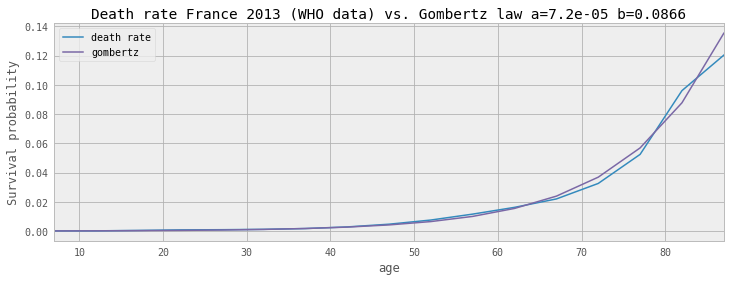

In [8]:
def pdf_gombertz(x, a, b):
    return a*np.exp(b*x)

def cdf_gombertz(x, a, b):
    return 1-np.exp(-(a/b)*(np.exp(b*x)-1))

a = 7.2e-5
b = np.log(2)/8
age = np.array(df2.index)
dr_gomb = pdf_gombertz(age, a, b)
df2['gombertz'] = dr_gomb

ax = df2.plot(figsize=(12, 4),
              title='Death rate France 2013 (WHO data) vs. Gombertz law a={} b={:.4f}'.format(a, b))
ax.set_ylabel('Survival probability');

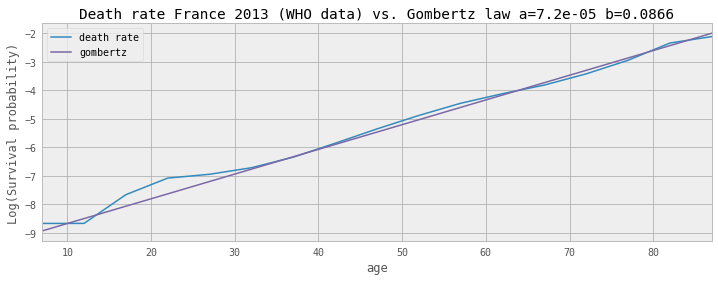

In [9]:
df2_log = np.log(df2)
ax = df2_log.plot(figsize=(12, 4),
                  title='Death rate France 2013 (WHO data) vs. Gombertz law a={} b={:.4f}'.format(a, b))
ax.set_ylabel('Log(Survival probability)');

**Pretty good match !**  
We can notice that for very old age it seems that actual death rate is a bit lower that the model.  

Now let us assume that such Gombertz law is valid.  
And compare the result with the **Accumulated Lightning Bolt model**.

First notice that France has approximately the same life expectancy as assumed above - according to [Wolfram Alpha](https://www.wolframalpha.com/input/?i=france+life+expectancy).  
So the comparison is (roughly) valid.  

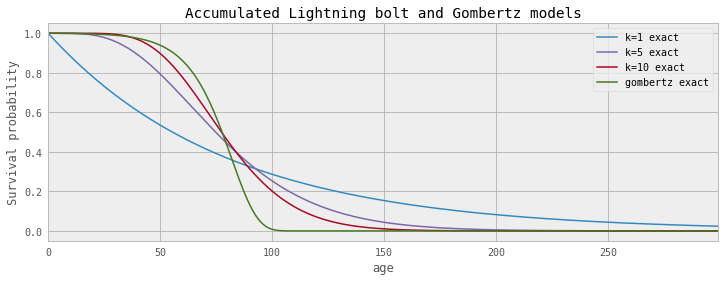

In [10]:
dr_gomb = pdf_gombertz(x, a, b)
y = cdf_gombertz(x, a, b)
df['gombertz exact'] = 1-y.copy()

ax = df.plot(figsize=(12, 4),
             title='Accumulated Lightning bolt and Gombertz models')
ax.set_ylabel('Survival probability');

The Gombertz curve seems closer to experience.  
In modern France - no war, famine, little crime (on average), good heath system (so far), good food (I think that won't change) - it is indeed relatively rare to die before 50 and exceptional to live 100 years.  
And there does seem to be a life expectancy wall a few years above 100.  

### Monte Carlo simulations

Let us check the Gombertz law distribution is correct by running a Monte Carlo simulation. 

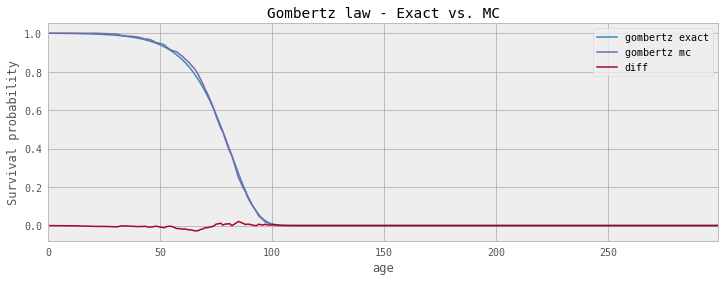

In [11]:
df3 = df[['gombertz exact']].copy()

li_pos = []
k = 1
for i in range(N_mc):
    events = np.where((rnd[i, :]<dr_gomb)==True)[0]
    pos_event = events[k-1] if len(events)>=k else max_age
    li_pos.append(pos_event)
age_death = np.array(li_pos)
hist, bin_edges = np.histogram(age_death, bins=np.arange(max_age), density=True)
y = np.r_[0, np.cumsum(hist*np.diff(bin_edges))]
df3['gombertz mc'] = 1-y.copy()

df3 = df3.assign(diff=(df3.iloc[:, 0]-df3.iloc[:, 1]))

ax = df3.plot(figsize=(12, 4),
              title='Gombertz law - Exact vs. MC')
ax.set_ylabel('Survival probability');

Ok.  
The curves are the almost the same even for a relatively small N_mc.

Now, let us have a closer look at the Gombertz law applied to modern France.

In [12]:
df_gomb = pd.DataFrame(index=pd.Index(data=x, name='age'), data=dr_gomb, columns=['yearly death rate'])


li = []
for a in np.arange(20, 115, 5):
    p = df_gomb.ix[a, 0]
    s = 1 if p < 0.5 else 2
    f = Fraction(1/p).limit_denominator().limit_denominator(s)
    li.append({'age': a,
               'prob death': '{:>8.3f} %'.format(100*p),
               'approx ratio': '{}/{}'.format(f.denominator, f.numerator)})
    
dfm = pd.DataFrame(li).set_index('age')
dfm

approx ratio  prob death
age                         
20        1/2455     0.041 %
25        1/1592     0.063 %
30        1/1032     0.097 %
35         1/669     0.149 %
40         1/434     0.230 %
45         1/281     0.355 %
50         1/182     0.548 %
55         1/118     0.845 %
60          1/77     1.303 %
65          1/50     2.010 %
70          1/32     3.100 %
75          1/21     4.781 %
80          1/14     7.373 %
85           1/9    11.370 %
90           1/6    17.536 %
95           1/4    27.044 %
100          1/2    41.707 %
105          2/3    64.321 %
110          1/1    99.196 %

## Conclusion

### Good fit with data
The Gombertz law is a very good fit to modern France death rate.  
France in turn is quite representative of the developped world in terms of health and mortality rates.  

### Old age deviation
The Gombertz law reaches 100% death rate at the age of 110.  
That seems a bit too definitive, but not that far from real life.  
The fact that the law does not seem as valid for old age is maybe due to the fact that there are not enough data at to be statistically meaningful.  
Or maybe some sort of adverse selection where those who survive that long are inherently (a bit) more robust that the rest of us.  

### A law of nature
Actually the Gombertz law is said to be valid among different populations (1) human across geographies and time, (2) animal of various species.  


### Some things to remember
Whatever you probability of dying this year, it will be double in 8 years.  
At the age of 65 when people typically retire they have a 1/50 chance of dying that year.  
At age 20 no need to worry about Gombertz, better focus on the car seat belt...  

### Read More
+ Fun: [Your body wasn't built to last: A lesson from human mortality rates](https://gravityandlevity.wordpress.com/2009/07/08/your-body-wasnt-built-to-last-a-lesson-from-human-mortality-rates/)

+ Academic: [Deciphering death: a commentary on Gompertz (1825) ‘On the nature of the function expressive of the law of human mortality, and on a new mode of determining the value of life contingencies’](http://rstb.royalsocietypublishing.org/content/370/1666/20140379)
